# Графическое представление информации

In [76]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [77]:
os.makedirs("../outputs/figures", exist_ok=True)
df = pd.read_csv("../outputs/data/processed/df_clean.csv")
print(df.shape)
df.head()

(3892, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


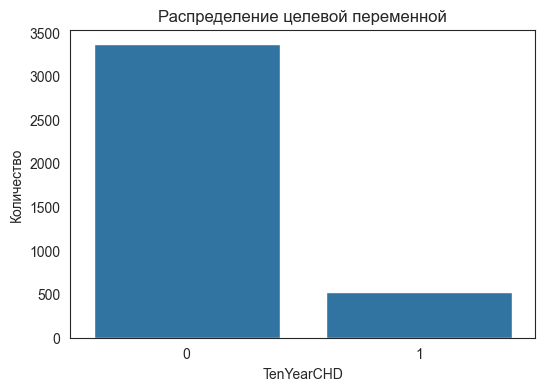

In [78]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="TenYearCHD")
plt.title("Распределение целевой переменной")
plt.xlabel("TenYearCHD")
plt.ylabel("Количество")
plt.savefig("../outputs/figures/01_TenYearCHD_count.png")
plt.show()

## Проверка гипотез
Есть ряд уже установленных зависимостей между признаками, которые были доказаны, попробуем изучить зависимости, проведя исследование:
1. Курение повышает риск развития ишемической болезни сердца (1960)
2. Холестерин и высокое артериальное давление повышают риск развития ИБС (1961)
3. Риск развития ишемической болезни сердца у мужчин выше, чем у женщин (1999)
4. Ожирение является фактором риска развития сердечной недостаточности (2002)

### Гипотеза 1: Курение повышает риск развития ишемической болезни сердца (1960)
Для проверки гипотезы была рассмотрена корреляция с итоговой метрикой не только для факта курения, но и для количества сигарет в день

Полученные выводы:
- Действительно, исследование показывает, что доля CHD у курильщиков несколько выше, чем у некурящих 
- Так же среднее количество сигарет в день у курильщиков с ИБС превышает (20.9 против 18.0), но при этом прямой зависимости не наблюдается

Доля CHD у некурящих: 0.123
Доля CHD у курящих:   0.148


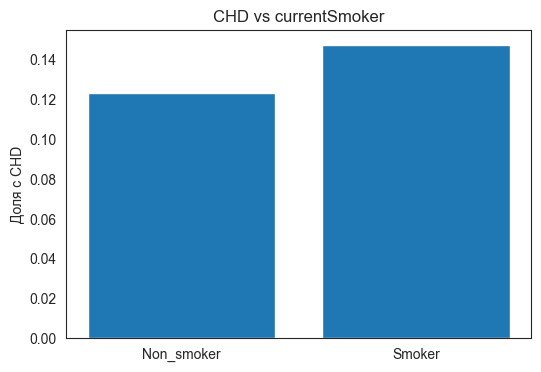

In [98]:
# Smoker / Non‑smoker
total = df.groupby("currentSmoker")["TenYearCHD"].count()
chd   = df.groupby("currentSmoker")["TenYearCHD"].sum()
prop  = (chd / total).values

# Небольшая статистика
print(f"Доля CHD у некурящих: {prop[0]:.3f}")
print(f"Доля CHD у курящих:   {prop[1]:.3f}")

# Столбчатая диаграмма
plt.figure(figsize=(6,4))
plt.bar(["Non_smoker", "Smoker"], prop)
plt.ylabel("Доля с CHD")
plt.title("CHD vs currentSmoker")
plt.savefig("../outputs/figures/02_Smoker_vs_CHD.png", bbox_inches="tight")
plt.show()


Среднее cigsPerDay без CHD: 18.0
Среднее cigsPerDay с CHD:   20.9


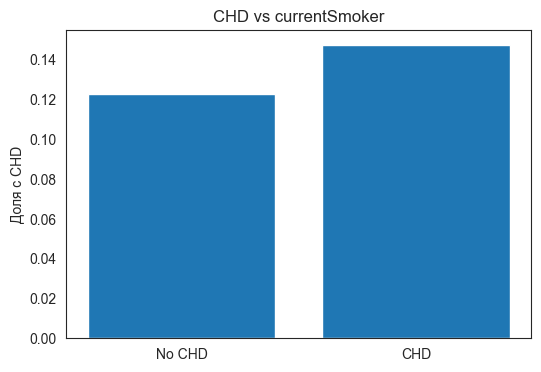

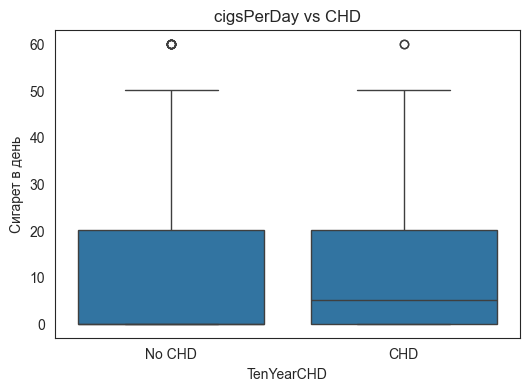

In [99]:
# Зависимость от количества сигарет
smokers = df[df['currentSmoker'] == 1]

# Небольшая статистика
mean_no = smokers.loc[(smokers['TenYearCHD'] == 0) & (smokers['cigsPerDay'] > 0), "cigsPerDay"].mean()
mean_yes = smokers.loc[(smokers['TenYearCHD'] == 1) & (smokers['cigsPerDay'] > 0), "cigsPerDay"].mean()
print(f"\nСреднее cigsPerDay без CHD: {mean_no:.1f}")
print(f"Среднее cigsPerDay с CHD:   {mean_yes:.1f}")

plt.figure(figsize=(6,4))
plt.bar(["No CHD", "CHD"], prop)
plt.ylabel("Доля с CHD")
plt.title("CHD vs currentSmoker")
plt.savefig("../outputs/figures/02_Smoker_vs_CHD.png", bbox_inches="tight")
plt.show()

# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x="TenYearCHD", y="cigsPerDay", data=df)
plt.xticks([0,1], ["No CHD","CHD"])
plt.title("cigsPerDay vs CHD")
plt.xlabel("TenYearCHD")
plt.ylabel("Сигарет в день")
plt.savefig("../outputs/figures/03_CigsPerDay_vs_CHD.png", bbox_inches="tight")
plt.show()

### 2: Исследование влияния холестерина и артериального давления на риск ИБС 

**Нулевая гипотеза (H0):**  
Уровень холестерина (`totChol`) и показатели артериального давления (`sysBP`, `diaBP`) не связаны с риском развития ишемической болезни сердца (`TenYearCHD`).

**Альтернативная гипотеза (H1):**  
Повышенные значения `totChol`, `sysBP` и `diaBP` статистически значимо коррелируют с вероятностью возникновения ИБС.

**Целевая переменная:** `TenYearCHD` (бинарная: 0/1)
**Предикторы:**
- `totChol`: общий холестерин (мг/дл)
- `sysBP`: систолическое артериальное давление (мм рт.ст.)
- `diaBP`: диастолическое артериальное давление (мм рт.ст.)

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import display

In [105]:
results = []

for col in ['totChol', 'sysBP', 'diaBP']:
    group_0 = df[df['TenYearCHD'] == 0][col]
    group_1 = df[df['TenYearCHD'] == 1][col]

    stat, p = stats.mannwhitneyu(group_0, group_1)

    d = (2 * stat) / (len(group_0) * len(group_1)) - 1
    effect_size = "малый" if abs(d) < 0.15 else "средний" if abs(d) < 0.30 else "большой"

    if p < 0.0001:
        p_formatted = "<0.0001"
    else:
        p_formatted = f"{p:.4f}"

    results.append({
        'Параметр': col,
        'U-критерий': f"{stat:.3f}",
        'p-value': p_formatted,
        'Размер эффекта': f'{d:.3f}: ({effect_size})'
    })

results_df = pd.DataFrame(results)
results_df

,Параметр,U-критерий,p-value,Размер эффекта
0,totChol,781588.500,<0.0001,-0.119: (малый)
1,sysBP,640515.500,<0.0001,-0.278: (средний)
2,diaBP,728586.500,<0.0001,-0.178: (средний)


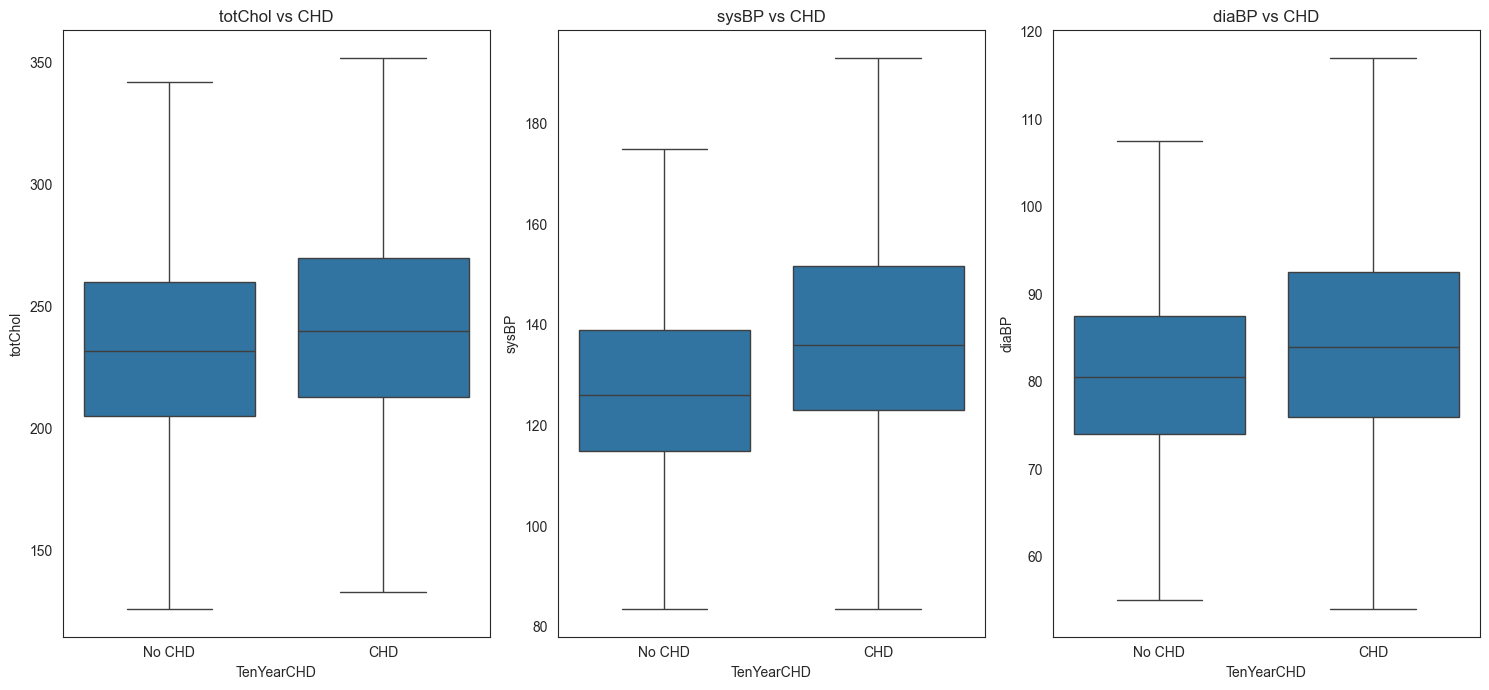

In [116]:
plt.figure(figsize=(15, 7))

for i, col in enumerate(['totChol', 'sysBP', 'diaBP'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='TenYearCHD', y=col, data=df, showfliers=False)
    
    plt.title(f"{col} vs CHD")
    plt.xticks([0,1], ["No CHD","CHD"])
plt.tight_layout()


In [ ]:
# Определение клинически значимых порогов
thresholds = {
    'sysBP': 140,  # Гипертония 1 стадии (ESC/ESH guidelines)
    'diaBP': 90,   # Гипертония 1 стадии
    'totChol': 240 # Высокий холестерин (NCEP ATP III)
}

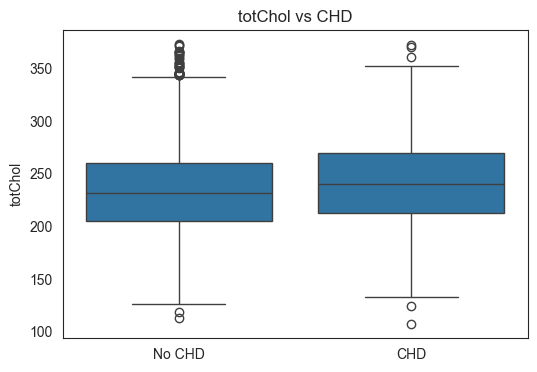

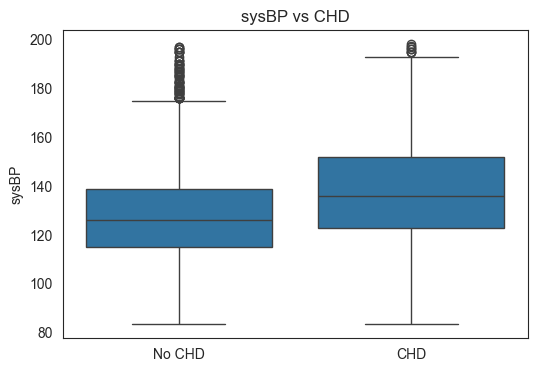

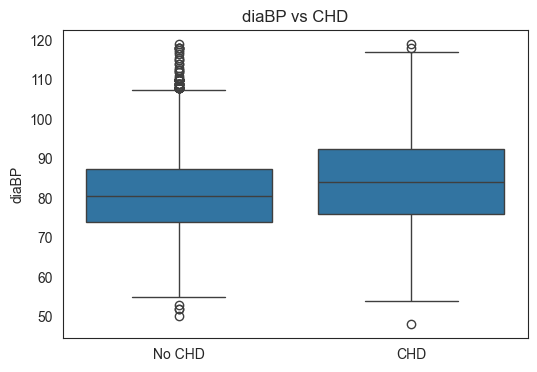

In [81]:
for col in ["totChol", "sysBP", "diaBP"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="TenYearCHD", y=col, data=df)
    plt.xticks([0,1], ["No CHD","CHD"])
    plt.title(f"{col} vs CHD")
    plt.xlabel("")
    plt.ylabel(col)
    fname = f"../outputs/figures/04_{col}_vs_CHD.png"
    plt.savefig(fname, bbox_inches="tight")
    plt.show()

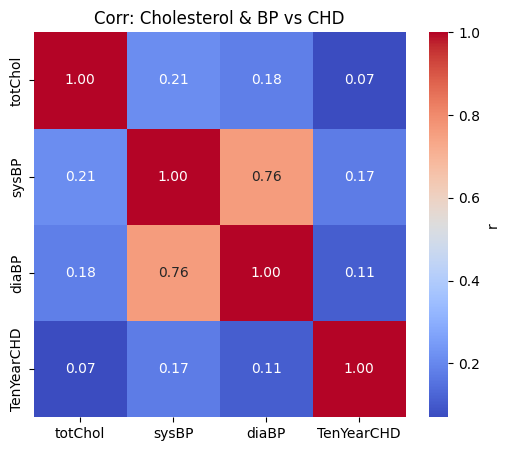

In [ ]:
corr_cols = ["totChol", "sysBP", "diaBP", "TenYearCHD"]
corr = df[corr_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
            cbar_kws={"label":"r"})
plt.title("Corr: Cholesterol & BP vs CHD")
plt.savefig("../outputs/figures/04_heatmap_chol_bp_chd.png", bbox_inches="tight")
plt.show()

In [ ]:
# 2. totChol, sysBP, diaBP vs CHD

In [ ]:
# 3. male vs TenYearCHD

In [ ]:
# 4. BMI vs TenYearCHD